# **CSE 7324 Lab 7: Recurrent Network Architectures**
### *Thomas Adams, Suleiman Hijazeen, Nancy Le and Andrew Whigham*
---

### **1. Preparation**
---


In [1]:
import json
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import sequence
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding


Using TensorFlow backend.


In [2]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    

In [3]:
#create custom f1 metric from custom recall and precision
from keras.layers import concatenate
from keras import backend as K

def recall_m(y_true, y_pred): # recall is true positive / (total actual positive)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # actual positives are just y_true
        # recall is true positive / (total actual positive).. the episol is a small number to prevent divide by zero errors
        recall = true_positives / (possible_positives + K.epsilon()) 
        return recall

def precision_m(y_true, y_pred): #precision is true positives / (total predicted positives)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
        # (true positive / predicted positive).. the episol is a small number to prevent divide by zero errors
        precision = true_positives / (predicted_positives + K.epsilon())   
        return precision

def f1_m(y_true, y_pred): # f1 = 2 * (precision*recall / precision + recall)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 

#### 1.1 Data Description
---

In [16]:
tweets = []
article_link = []
headline=[]
y = []
#tokenizer = Tokenizer(num_words=1000)
for line in open('Data/Sarcasm_Headlines_Dataset.json', 'r'):
    tweets.append(json.loads(line))
    article_link.append(tweets[len(tweets)-1]['article_link'])
    headline.append(tweets[len(tweets)-1]['headline'])
    y.append(tweets[len(tweets)-1]['is_sarcastic'])

In [17]:
NUM_TOP_WORDS = None
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(headline)
sequences = tokenizer.texts_to_sequences(headline)

In [18]:
MAX_ART_LEN = 500 # maximum and minimum number of words
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))


Found 29656 unique tokens. Distilled to 29656 top words.


In [19]:
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

In [20]:
y_ohe = keras.utils.to_categorical(y)

#### 1.1 Metric Evaluation
---

#### 1.2 Splitting Data
---

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
sss=StratifiedShuffleSplit(n_splits=3, random_state=7,train_size = .8,test_size = .2,)
# Split it into train / test subsets

# X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
#                                                            stratify=y, 
#                                                            random_state=42)

### **2. Modeling**
---


#### 2.1 Investigating Two RNNs
---

In [23]:
import numpy as np
NUM_CLASSES = 2

In [ ]:

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))

input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = SimpleRNN(50,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
print(rnn.summary())

In [27]:
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                          stratify=y,
                                                         random_state=42)

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))


history1=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


 x = SimpleRNN(50,dropout=0.2, recurrent_dropout=0.2)(input_embed)
 x = Dense(NUM_CLASSES, activation='sigmoid')(x)
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 rnn=Model(inputs=input_holder,outputs=x)
 rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]   
 history1.append(rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
TRAIN: (21367,) TEST: (5342,)
Instructions for updating:
Use tf.cast instead.
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 31s 1ms/step - loss: 0.6985 - acc: 0.5306 - f1_m: 0.5296 - val_loss: 0.6691 - val_acc: 0.6034 - val_f1_m: 0.5555
Epoch 2/5
21367/21367 [==============================] - 30s 1ms/step - loss: 0.6633 - acc: 0.5968 - f1_m: 0.6008 - val_loss: 0.6586 - val_acc: 0.5826 - val_f1_m: 0.5993
Epoch 3/5
21367/21367 [==============================] - 31s 1ms/step - loss: 0.6076 - acc: 0.6705 - f1_m: 0.6714 - val_loss: 0.5440 - val_acc: 0.7549 - val_f1_m: 0.7495
Epoch 4/5
21367/21367 [==============================] - 31s 1ms/step - loss: 0.4976 - acc: 0.7659 - f1_m: 0.7658 - val_loss: 0.4830 - val_acc: 0.7735 - val_f1_m: 0.7731
Epoch 

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history2=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls = Sequential()
 rnnls.add(input_embed)
 rnnls.add(LSTM(50,dropout=0.2, recurrent_dropout=0.2))
 rnnls.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history2.append(rnnls.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 73s 3ms/step - loss: 0.4850 - acc: 0.7566 - f1_m: 0.7536 - val_loss: 0.3567 - val_acc: 0.8501 - val_f1_m: 0.8439
Epoch 2/5
21367/21367 [==============================] - 72s 3ms/step - loss: 0.2985 - acc: 0.8744 - f1_m: 0.8720 - val_loss: 0.3164 - val_acc: 0.8639 - val_f1_m: 0.8608
Epoch 3/5
21367/21367 [==============================] - 72s 3ms/step - loss: 0.2439 - acc: 0.9032 - f1_m: 0.9011 - val_loss: 0.3142 - val_acc: 0.8637 - val_f1_m: 0.8620
Epoch 4/5
21367/21367 [==============================] - 72s 3ms/step - loss: 0.2213 - acc: 0.9144 - f1_m: 0.9142 - val_loss: 0.3151 - val_acc: 0.8677 - val_f1_m: 0.8651
Epoch 5/5
21367/21367 [==============================] - 73s 3ms/step - loss: 0.1918 - acc: 0.9263 - f1_m: 0.9253 - val_loss: 0.3158 - val_acc: 0.8678 - val_f1_m: 0.8656
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
history3=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnngd = Sequential()
 rnngd.add(input_embed)
 rnngd.add(GRU(50,dropout=0.2, recurrent_dropout=0.2))
 rnngd.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnngd.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnngd.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history3.append(rnngd.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnngd.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 61s 3ms/step - loss: 0.4746 - acc: 0.7666 - f1_m: 0.7610 - val_loss: 0.3429 - val_acc: 0.8519 - val_f1_m: 0.8498
Epoch 2/5
21367/21367 [==============================] - 60s 3ms/step - loss: 0.2951 - acc: 0.8781 - f1_m: 0.8763 - val_loss: 0.3178 - val_acc: 0.8635 - val_f1_m: 0.8611
Epoch 3/5
21367/21367 [==============================] - 60s 3ms/step - loss: 0.2352 - acc: 0.9055 - f1_m: 0.9041 - val_loss: 0.3118 - val_acc: 0.8677 - val_f1_m: 0.8659
Epoch 4/5
21367/21367 [==============================] - 60s 3ms/step - loss: 0.2034 - acc: 0.9223 - f1_m: 0.9205 - val_loss: 0.3063 - val_acc: 0.8716 - val_f1_m: 0.8690
Epoch 5/5
21367/21367 [==============================] - 61s 3ms/step - loss: 0.1768 - acc: 0.9318 - f1_m: 0.9306 - val_loss: 0.3113 - val_acc: 0.8765 - val_f1_m: 0.8726
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 

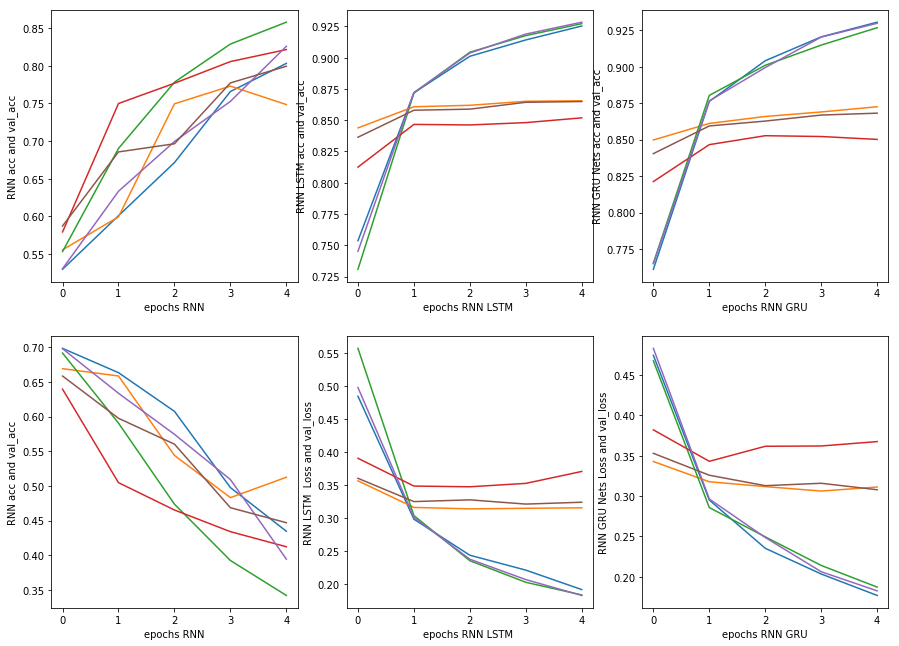

In [30]:
plt.figure(figsize=(15,11))
plt.subplot(2,3,1)
plt.ylabel('RNN acc and val_acc')
plt.xlabel('epochs RNN')
plt.plot(history1[0].history['f1_m'])

plt.plot(history1[0].history['val_f1_m'])
plt.plot(history1[1].history['f1_m'])

plt.plot(history1[1].history['val_f1_m'])
plt.plot(history1[2].history['f1_m'])

plt.plot(history1[2].history['val_f1_m'])
plt.subplot(2,3,4)
plt.ylabel('RNN acc and val_acc')
plt.plot(history1[0].history['loss'])
plt.xlabel('epochs RNN')
plt.plot(history1[0].history['val_loss'])

plt.plot(history1[1].history['loss'])
plt.plot(history1[1].history['val_loss'])
plt.plot(history1[2].history['loss'])
plt.plot(history1[2].history['val_loss']) 
         
plt.subplot(2,3,2)
plt.ylabel('RNN LSTM acc and val_acc')
plt.xlabel('epochs RNN LSTM ')
plt.plot(history2[0].history['f1_m'])
plt.plot(history2[0].history['val_f1_m'])
plt.plot(history2[1].history['f1_m'])
plt.plot(history2[1].history['val_f1_m'])
plt.plot(history2[2].history['f1_m'])
plt.plot(history2[2].history['val_f1_m'])
plt.subplot(2,3,5)
plt.plot(history2[0].history['loss'])
plt.ylabel('RNN LSTM  Loss and val_loss')
plt.plot(history2[0].history['val_loss'])
plt.xlabel('epochs RNN LSTM ')
plt.plot(history2[1].history['loss'])
plt.plot(history2[1].history['val_loss'])
plt.plot(history2[2].history['loss'])
plt.plot(history2[2].history['val_loss'])
plt.subplot(2,3,3)
plt.ylabel('RNN GRU Nets acc and val_acc')
plt.xlabel('epochs RNN GRU')
plt.plot(history3[0].history['f1_m'])
plt.plot(history3[0].history['val_f1_m'])
plt.plot(history3[1].history['f1_m'])
plt.plot(history3[1].history['val_f1_m'])
plt.plot(history3[2].history['f1_m'])
plt.plot(history3[2].history['val_f1_m'])
plt.subplot(2,3,6)
plt.plot(history3[0].history['loss'])
plt.ylabel('RNN GRU Nets Loss and val_loss')
plt.plot(history3[0].history['val_loss'])
plt.xlabel('epochs RNN GRU')
plt.plot(history3[1].history['loss'])
plt.plot(history3[1].history['val_loss'])
plt.plot(history3[2].history['loss'])
plt.plot(history3[2].history['val_loss'])




In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history4=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls1 = Sequential()
 rnnls1.add(input_embed)
 rnnls1.add(LSTM(100,dropout=0.3,recurrent_dropout=0.3))
 rnnls1.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history4.append(rnnls1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls1.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 87s 4ms/step - loss: 0.5024 - acc: 0.7550 - f1_m: 0.7500 - val_loss: 0.3514 - val_acc: 0.8465 - val_f1_m: 0.8412
Epoch 2/5
21367/21367 [==============================] - 87s 4ms/step - loss: 0.3247 - acc: 0.8649 - f1_m: 0.8622 - val_loss: 0.3217 - val_acc: 0.8633 - val_f1_m: 0.8598
Epoch 3/5
21367/21367 [==============================] - 87s 4ms/step - loss: 0.2707 - acc: 0.8906 - f1_m: 0.8886 - val_loss: 0.3106 - val_acc: 0.8714 - val_f1_m: 0.8685
Epoch 4/5
21367/21367 [==============================] - 87s 4ms/step - loss: 0.2471 - acc: 0.9056 - f1_m: 0.9039 - val_loss: 0.3137 - val_acc: 0.8701 - val_f1_m: 0.8680
Epoch 5/5
21367/21367 [==============================] - 87s 4ms/step - loss: 0.2333 - acc: 0.9124 - f1_m: 0.9118 - val_loss: 0.3142 - val_acc: 0.8738 - val_f1_m: 0.8726
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history4=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls1 = Sequential()
 rnnls1.add(input_embed)
 rnnls1.add(LSTM(100,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))
 rnnls1.add(LSTM(100,dropout=0.3,recurrent_dropout=0.3))   
 rnnls1.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history4.append(rnnls1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls1.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 181s 8ms/step - loss: 0.5239 - acc: 0.7190 - f1_m: 0.7360 - val_loss: 0.3488 - val_acc: 0.8514 - val_f1_m: 0.8492
Epoch 2/5
21367/21367 [==============================] - 178s 8ms/step - loss: 0.3398 - acc: 0.8398 - f1_m: 0.8462 - val_loss: 0.3250 - val_acc: 0.8587 - val_f1_m: 0.8542
Epoch 3/5
21367/21367 [==============================] - 177s 8ms/step - loss: 0.2515 - acc: 0.8994 - f1_m: 0.8960 - val_loss: 0.3225 - val_acc: 0.8602 - val_f1_m: 0.8606
Epoch 4/5
21367/21367 [==============================] - 177s 8ms/step - loss: 0.2117 - acc: 0.9166 - f1_m: 0.9150 - val_loss: 0.3176 - val_acc: 0.8695 - val_f1_m: 0.8692
Epoch 5/5
21367/21367 [==============================] - 177s 8ms/step - loss: 0.2497 - acc: 0.9010 - f1_m: 0.8665 - val_loss: 0.4158 - val_acc: 0.8068 - val_f1_m: 0.5277
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 

#### 2.2 RNN Chaining
---

#### 2.2 RNN Evaluation
---

In [33]:
import numpy as np
from mlxtend.evaluate import mcnemar_table
tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_model1, 
                   y_model2=y_model2)

print(tb)

ModuleNotFoundError: No module named 'mlxtend'

### **3. Exceptional Work: t-SNE**
---


### **4. References**
---


[1] https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home